# Wrangling, Analysis & Visualization: WeRateDogs Tweets

##### Import packages

In [173]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import tweepy
import statsmodels.api as sm
from sqlalchemy import create_engine
from tqdm import tqdm

##### Tweepy config

In [3]:
import config # File containing personal API keys.

# Replace config variables with your API keys.
consumer_key = config.consumer_key  
consumer_secret = config.consumer_secret  
access_token = config.access_token
access_secret = config.access_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Gather

##### WeRateDogs Twitter Archive

In [4]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

##### Neural Network Image Predictions downloaded from Udacity's servers

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

open('image-predictions.tsv', 'wb').write(r.content)

df_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

##### Tweet Length, Retweet Count & Favorite Count using Twitter's API  

In [293]:
tweet_json = []
tweet_errors = []

# Process may take ~20-30 mins because of Twitter API's rate limit.
for tweet_id in tqdm(twitter_archive_enhanced.tweet_id):
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        tweet_record = tweet._json
        
        tweet_json.append(tweet_record)
        
    except Exception as e:
        tweet_errors.append({'tweet_id':tweet_id,
                             'error':str(e)[2:-2]})

100%|██████████| 2356/2356 [26:12<00:00,  5.42it/s]    


In [ ]:
with open('tweet_json.txt', 'w') as outfile:
    outfile.write(
        '[' +
        ',\n'.join(json.dumps(record) for record in tweet_json) +
        ']\n')

In [6]:
with open('tweet_json.txt') as json_data:
    json_list = [] 
    obj = json.load(json_data)
    for record in obj:
        json_list.append({'tweet_id': record['id'],
                          'retweet_count': record['retweet_count'],
                          'favorite_count': record['favorite_count'],
                          'tweet_length': record['display_text_range'][1]})

df_tweet_json = pd.DataFrame(json_list)

## Assess

#### Tidiness
* All DataFrames should be inner joined on `tweet_id`.
* `doggo`, `floofer`, `pupper` & `puppo` columns should be a single `dogscription` column.
* Retweet related columns can be removed after retweet records are removed.

#### Quality
##### `df_twitter_archive`
* 183 of the tweets are retweets.
* `rating_numerator` and `rating_denominator` are sometimes wrong.
* Remove ratings for non-dog tweets and correct numerators that have errors.
* `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` & `retweeted_status_user_id` should be formatted as strings to fix scientific notation.
* `timestamp` is formatted as strings.
* 109 misidentified names & 745 "None" string values in `name` column. "O" should be "O'Malley". "None" strings should be None type.
* `source` column contains HTML tags.
* Only 2075 `tweet_id`'s had records in `df_image_predictions`. The 281 missing from `df_image_predictions` should be dropped.
* Make `timestamp` display in Eastern time since that's where the account owner lives.

##### `df_image_predictions`
* Images with 'False' values for all 3 of `p1_dog`, `p2_dog` & `p3_dog` are unlikely to contain images of dogs.
* Multi-word predictions in columns `p1`, `p2` & `p3` use '_' instead of spaces.

In [7]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
# Retweets have 'RT' at the beginning of 'text'.
df_twitter_archive[df_twitter_archive.retweeted_status_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [10]:
# 2 additional retweets were found by indexing the 'text' column. 
    # Index 1286 & 1860 have 'RT' at the beginning, but are missing the @user_name. A total of 183 are retweets.
df_twitter_archive[df_twitter_archive.text.str[0:2] == 'RT']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [11]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [12]:
print(df_twitter_archive[df_twitter_archive.rating_denominator != 10].rating_denominator.count())
df_twitter_archive.rating_denominator.value_counts()

23


10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [13]:
# 23 tweets have denominators not matching the standard rating system. Some tweets have multiple fractions or dates throwing
    # off the rating columns. Other tweets have ratings for multiple dogs in one fraction. 
with pd.option_context('display.max_colwidth', -1):
    display(df_twitter_archive[df_twitter_archive.rating_denominator != 10])

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184

In [14]:
# Many values in the 'names' column aren't actual names.
for name in sorted(df_twitter_archive.name.unique()):
    print(name)

Abby
Ace
Acro
Adele
Aiden
Aja
Akumi
Al
Albert
Albus
Aldrick
Alejandro
Alexander
Alexanderson
Alf
Alfie
Alfy
Alice
Amber
Ambrose
Amy
Amélie
Anakin
Andru
Andy
Angel
Anna
Anthony
Antony
Apollo
Aqua
Archie
Arlen
Arlo
Arnie
Arnold
Arya
Ash
Asher
Ashleigh
Aspen
Astrid
Atlas
Atticus
Aubie
Augie
Autumn
Ava
Axel
Bailey
Baloo
Balto
Banditt
Banjo
Barclay
Barney
Baron
Barry
Batdog
Bauer
Baxter
Bayley
BeBe
Bear
Beau
Beckham
Beebop
Beemo
Bell
Bella
Belle
Ben
Benedict
Benji
Benny
Bentley
Berb
Berkeley
Bernie
Bert
Bertson
Betty
Beya
Biden
Bilbo
Billl
Billy
Binky
Birf
Bisquick
Blakely
Blanket
Blipson
Blitz
Bloo
Bloop
Blu
Blue
Bluebert
Bo
Bob
Bobb
Bobbay
Bobble
Bobby
Bode
Bodie
Bonaparte
Bones
Bookstore
Boomer
Boots
Boston
Bowie
Brad
Bradlay
Bradley
Brady
Brandi
Brandonald
Brandy
Brat
Brian
Brockly
Brody
Bronte
Brooks
Brownie
Bruce
Brudge
Bruiser
Bruno
Brutus
Bubba
Bubbles
Buckley
Buddah
Buddy
Bungalo
Burt
Butter
Butters
Cal
Calbert
Cali
Callie
Calvin
Canela
Cannon
Carbon
Carl
Carll
Carly
Carper
Carter


In [15]:
# "O" should be "O'Malley"
df_twitter_archive.loc[df_twitter_archive.name == 'O']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521...,10,10,O,None,None,None,None


In [16]:
# 109 misidentified names and 745 "None" values.
print(df_twitter_archive[~df_twitter_archive.name.str[0].str.istitle()].name.value_counts().sum())
df_twitter_archive[~df_twitter_archive.name.str[0].str.istitle()].name.value_counts()

109


a               55
the              8
an               7
very             5
just             4
quite            4
one              4
mad              2
getting          2
not              2
actually         2
all              1
his              1
by               1
incredibly       1
space            1
infuriating      1
my               1
such             1
light            1
old              1
this             1
officially       1
life             1
unacceptable     1
Name: name, dtype: int64

In [17]:
# Source values contain unnecessary HTML tags.
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
# Only 2075 tweets have images.
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
# 'All 2075 tweet_id's from df_image_predictions appear in df_twitter_archive, but there are 281 extra in df_twitter_archive.
print(len(df_image_predictions.tweet_id.isin(df_twitter_archive.tweet_id)))
print(len(df_twitter_archive.tweet_id) - len(df_image_predictions.tweet_id))

2075
281


In [20]:
# Some image predictions are wrong. 
df_image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
901,700002074055016451,https://pbs.twimg.com/media/CbboKP4WIAAw8xq.jpg,1,Chihuahua,0.369488,True,schipperke,0.243367,True,pug,0.161614,True
1853,840696689258311684,https://pbs.twimg.com/media/C6rBLenU0AAr8MN.jpg,1,web_site,0.841768,False,rule,0.007087,False,envelope,0.006820,False
1792,830956169170665475,https://pbs.twimg.com/ext_tw_video_thumb/83095...,1,kuvasz,0.451516,True,golden_retriever,0.317196,True,English_setter,0.132759,True
102,667801013445750784,https://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg,1,flat-coated_retriever,0.508392,True,Chesapeake_Bay_retriever,0.262239,True,curly-coated_retriever,0.048920,True
531,676821958043033607,https://pbs.twimg.com/media/CWSN-vaXAAA8Ehr.jpg,2,Great_Pyrenees,0.869804,True,kuvasz,0.079814,True,standard_poodle,0.013263,True


In [21]:
# Only 1751 tweets have at least one dog breed prediction.
df_image_predictions[((df_image_predictions.p1_dog == 1) | (df_image_predictions.p2_dog == 1) |\
                      (df_image_predictions.p3_dog == 1))]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True


## Clean

In [22]:
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_tweet_json_clean = df_tweet_json.copy()

#### Define
* Merge all DataFrames into `df` and make a copy for further cleaning. Inner join also removes any records that weren't in `df_image_predictions`.

#### Code

In [23]:
# Merge df_twitter_archive_clean, df_tweet_json_clean & df_image_predictions_clean.
df = df_twitter_archive_clean.merge(df_tweet_json_clean, on='tweet_id').merge(df_image_predictions_clean, on='tweet_id')

In [24]:
# Copy df.
df_clean = df.copy()

#### Test

In [25]:
# All columns appear in df_clean.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 0 to 2066
Data columns (total 31 columns):
tweet_id                      2067 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2067 non-null object
source                        2067 non-null object
text                          2067 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2067 non-null object
rating_numerator              2067 non-null int64
rating_denominator            2067 non-null int64
name                          2067 non-null object
doggo                         2067 non-null object
floofer                       2067 non-null object
pupper                        2067 non-null object
puppo                         2067 non-null object
favorite_count                2067 

#### Define
* Combine `doggo`, `floofer`, `pupper` & `puppo` into a single `dogscription` column.

#### Code

In [26]:
# Combine all 4 'dog_stage' columns and drop the originals.
df_clean['dogscription'] = \
df_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')['doggo']+\
df_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')['floofer']+\
df_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')['pupper']+\
df_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')['puppo']
df_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

In [27]:
# Fix records with values from multiple columns or '' names.
df_clean['dogscription'].replace({'doggopupper':'doggo pupper', 
                                                'doggofloofer':'doggo floofer',
                                                'doggopuppo':'doggo puppo',
                                                '':None}, inplace=True)

#### Test

In [28]:
# All 'dogscriptions' are formatted correctly.
df_clean['dogscription'].value_counts()

pupper           210
doggo             67
puppo             23
doggo pupper      11
floofer            7
doggo floofer      1
doggo puppo        1
Name: dogscription, dtype: int64

#### Define
* Drop all retweets from `df_clean` and remove `retweeted_status_id`, `retweeted_status_user_id` & `retweeted_status_timestamp` columns.

#### Code

In [29]:
# Remove all tweets that have 'RT' at the beginning of their 'text' field.
df_clean.drop(df_clean[df_clean.text.str[0:2] == 'RT'].index, inplace=True)

In [30]:
# Drop 'retweeted_status_id', 'retweeted_status_user_id' & 'retweeted_status_timestamp' columns.
df_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

#### Test

In [31]:
# Tweets starting with 'RT' have been removed.
df_clean[df_clean.text.str[0:2] == 'RT']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dogscription


In [32]:
# Retweet related columns have been removed.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 2066
Data columns (total 25 columns):
tweet_id                 1992 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1992 non-null object
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null int64
rating_denominator       1992 non-null int64
name                     1992 non-null object
favorite_count           1992 non-null int64
retweet_count            1992 non-null int64
tweet_length             1992 non-null int64
jpg_url                  1992 non-null object
img_num                  1992 non-null int64
p1                       1992 non-null object
p1_conf                  1992 non-null float64
p1_dog                   1992 non-null bool
p2                       1992 non-null object
p2_conf                  1992

#### Define
* Extract correct dog rating where possible and remove any records with unusable ratings. Only tweets with a 10 point denominator should remain.

#### Code

In [33]:
# Remove tweets that lack a usable rating.
unusable_tweets = [341, 411, 729, 918, 1016, 1041, 1059, 1125, 1201, 1373, 1374, 1506, 1565]
df_clean.drop(unusable_tweets, inplace=True)

In [34]:
# Extract and correct 'rating_numerator' then set 'rating_denominator' to 10.
df_clean.loc[df_clean[df_clean.rating_denominator != 10].index, 'rating_numerator'] =\
             df_clean[df_clean.rating_denominator != 10].text.str.extract(r'(\d+)/(10)').iloc[:][0].astype(np.int64)

df_clean.loc[df_clean[df_clean.rating_denominator != 10].index, 'rating_denominator'] = 10

#### Test

In [35]:
# All ratings now have a 10 in their denominator.
df_clean[df_clean.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dogscription


#### Define
* Remove ratings for non-dog tweets and correct numerators that have errors.

#### Code

In [91]:
# 673906403526995968 is a cat, 718246886998687744 is a plastic dog, 777885040357281792 is a goat, 666649482315059201 is a cow,
    # 667176164155375616 are alpacas, 671122204919246848 are ducks, 680940246314430465 is a sheep, 707420581654872064 is a goat,
    # 683849932751646720 is a pig, 672980819271634944 is a giraffe, 668994913074286592 are goats, 835152434251116546 is about 
    # plagirism, 786709082849828864, 778027034220126208, 680494726643068929, and 883482846933004288 are ratings with decimals 
    # that were pulled wrong.
unusable_tweet_ids = [673906403526995968, 718246886998687744, 777885040357281792, 666649482315059201, 667176164155375616,\
                      671122204919246848, 680940246314430465, 707420581654872064, 683849932751646720, 672980819271634944,\
                      668994913074286592, 835152434251116546, 786709082849828864, 778027034220126208, 680494726643068929,\
                      883482846933004288]
df_clean = df_clean[~df_clean['tweet_id'].isin(unusable_tweet_ids)]

In [92]:
# 674646392044941312 should be an 8.
df_clean.loc[df_clean.query('tweet_id == 674646392044941312').index, 'rating_numerator'] = 8

# 667878741721415682 should be a 12.
df_clean.loc[df_clean.query('tweet_id == 667878741721415682').index, 'rating_numerator'] = 12

C:\Users\Ernest\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Test

In [95]:
# Unusable tweets are no longer in df_clean.
df_clean[df_clean['tweet_id'].isin(unusable_tweet_ids)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dogscription


In [93]:
# 674646392044941312's numerator is now 8.
df_clean.loc[df_clean.query('tweet_id == 674646392044941312').index, 'rating_numerator']

1621    8
Name: rating_numerator, dtype: int64

In [94]:
# 667878741721415682's numerator is now 12.
df_clean.loc[df_clean.query('tweet_id == 667878741721415682').index, 'rating_numerator']

1958    12
Name: rating_numerator, dtype: int64

#### Define
* Format `in_reply_to_status_id` & `in_reply_to_user_id` as strings.

#### Code

In [36]:
# Fill 'NaN' values with -1 and convert to int64 to correct number formatting. Then convert to strings and replace 
    # '-1' with 'NaN'.
df_clean[['in_reply_to_status_id', 'in_reply_to_user_id']] = df_clean[['in_reply_to_status_id', 'in_reply_to_user_id']]\
                                                                    .fillna(-1).astype(np.int64).astype(str).replace('-1', 'NaN')

#### Test

In [37]:
# Both columns contain strings.
print(type(df_clean['in_reply_to_status_id'][0]))
print(type(df_clean['in_reply_to_user_id'][0]))

<class 'str'>
<class 'str'>


#### Define
* Reformat `timestamp` as pd.datetime

#### Code

In [38]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)

#### Test

In [39]:
df_clean.timestamp.head(1) 

0   2017-08-01 16:23:56
Name: timestamp, dtype: datetime64[ns]

#### Define
* Remove/fix misidentified names & "None" values in `name` column of `df_clean` and change "O" to "O'Malley".

#### Code

In [40]:
# Get indices of missnamed and 'None' values
dog_name_error_indices = df_clean.loc[(~df_clean.name.str[0].str.istitle()) | (df_clean.name == 'None')].index

In [41]:
# Replace all lowercase/'None' values with names extracted from tweet text.
df_clean.loc[dog_name_error_indices, 'name'] =\
df_clean.loc[dog_name_error_indices].text.str.extract(r'([Nn]ame is|[Nn]amed) ([A-Z]\w+)')[1]

In [42]:
# Change all np.nan values to None type.
df_clean.loc[df_clean.name.isnull(), 'name'] = None

In [43]:
# Change "O" to "O'Malley"
df_clean.loc[619, 'name'] = "O'Malley"

#### Test

In [44]:
# "None" and lowercase names no longer appear.
df_clean.name.value_counts()

Charlie      10
Cooper       10
Oliver       10
Lucy         10
Tucker        9
Penny         9
Sadie         8
Winston       8
Daisy         7
Lola          7
Toby          7
Jax           6
Koda          6
Bo            6
Stanley       6
Bella         6
Chester       5
Bailey        5
Scout         5
Buddy         5
Dave          5
Leo           5
Rusty         5
Oscar         5
Milo          5
Zoey          5
Louis         5
George        4
Maggie        4
Winnie        4
             ..
Geno          1
Reptar        1
Wishes        1
Jackie        1
Loomis        1
Bonaparte     1
Hubertson     1
Rocco         1
Godzilla      1
Ivar          1
Rontu         1
Dallas        1
Pluto         1
Bones         1
Kyro          1
Kellogg       1
Fabio         1
Wiggles       1
Kramer        1
Norman        1
Kollin        1
Pippin        1
Spencer       1
Bruno         1
Jazzy         1
Apollo        1
Simba         1
Iggy          1
Berkeley      1
Ken           1
Name: name, Length: 936,

In [45]:
# Index 775 is no longer named "O"
df_clean.loc[619, 'name']

"O'Malley"

#### Define
* Simplify `source` column values.

#### Code

In [46]:
# Extract description text between tags and simplify them as one-word.
df_clean['source'] = df_clean.source.str.extract(r'>(.+)</a>')[0].replace({'Twitter for iPhone':'iPhone',
                                                                           'Twitter Web Client':'Web',
                                                                           'Vine - Make a Scene':'Vine'})

#### Test

In [47]:
# All sources are simple and descriptive.
df_clean['source'].value_counts()

iPhone       1940
Web            28
TweetDeck      11
Name: source, dtype: int64

#### Define
* Remove records of images that are unlikely to be dogs.

#### Code

In [48]:
# Remove tweets that don't have at least one dog breed prediction
df_clean = df_clean.loc[((df_clean.p1_dog == 1) | (df_clean.p2_dog == 1) | (df_clean.p3_dog == 1))]

#### Test

In [49]:
# Only records with at least one dog breed prediction remain.
len(df_clean.loc[~((df_clean.p1_dog == 1) | (df_clean.p2_dog == 1) | (df_clean.p3_dog == 1))])

0

#### Define
* Reformat image prediction names in columns `p1`, `p2`, & `p3` by replacing underscores with spaces.

#### Code

In [50]:
# Use .applymap() to replace underscores with spaces.
df_clean[['p1', 'p2', 'p3']] = df_clean[['p1', 'p2', 'p3']].applymap(lambda x: x.replace('_', ' '))

#### Test

In [51]:
# Multi-word predictions no longer have underscores.
df_clean[['p1', 'p2', 'p3']].sample(3)

,p1,p2,p3
1726,Irish terrier,Airedale,toy poodle
70,Pembroke,Cardigan,basenji
1070,muzzle,basenji,Boston bull


#### Define
* Adjust `timestamp` column to Eastern time. 

#### Code

In [52]:
# Subtract 4 hours from 'timestamp' column.
df_clean['timestamp'] = df_clean.timestamp - pd.Timedelta(hours=4)

#### Test

In [53]:
# The timestamp is now in local time of the account owner.
df_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dogscription
1,892177421306343426,NaN,NaN,2017-07-31 20:17:27,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None


## Safe `df_clean` to database and csv

In [96]:
engine = create_engine('sqlite:///twitter_archive.db')

In [97]:
df_clean.to_sql('master', engine, index=False)

In [98]:
df_clean.to_csv('twitter_archive_master.csv', index=False)

## Analysis & Visualization

In [174]:
# Make graphs more visually appealing.
matplotlib.style.use('ggplot')

In [175]:
# Make a DataFrame with columns to be used in analysis & add a column with the hour the tweet was posted.
df_analysis = df_clean[['tweet_id', 'timestamp', 'source', 'rating_numerator', 'favorite_count', 'retweet_count',\
                        'tweet_length']].copy()

df_analysis['hour_posted'] = df_analysis.timestamp.dt.hour

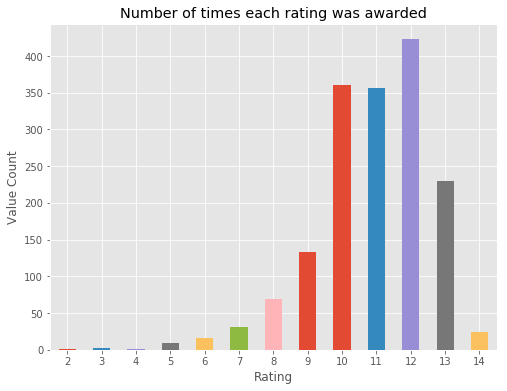

In [176]:
# Make a bar chart depicting the number of times each rating was awarded.
df_analysis.groupby(df_analysis.rating_numerator).favorite_count.count().plot(kind='bar', figsize=(8,6), rot=0)
plt.title('Number of times each rating was awarded')
plt.ylabel('Value Count')
plt.xlabel('Rating');

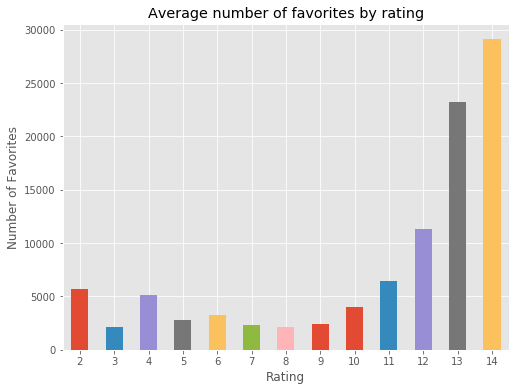

In [177]:
# Make a bar chart depicting the average number of favorites that tweets received at each rating.
df_analysis.groupby(df_analysis.rating_numerator).favorite_count.mean().plot(kind='bar', figsize=(8,6), rot=0)
plt.title('Average number of favorites by rating')
plt.ylabel('Number of Favorites')
plt.xlabel('Rating');

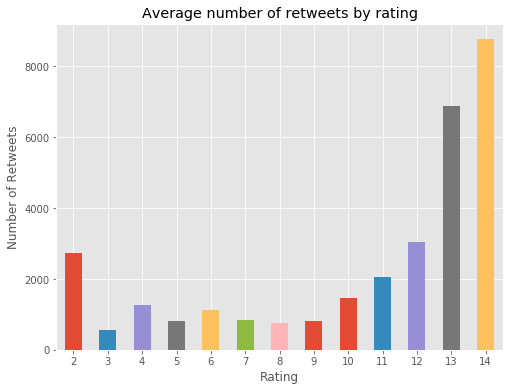

In [178]:
# Make a bar chart depicting the average number of retweets that tweets received at each rating.
df_analysis.groupby(df_analysis.rating_numerator).retweet_count.mean().plot(kind='bar', figsize=(8,6), rot=0)
plt.title('Average number of retweets by rating')
plt.ylabel('Number of Retweets')
plt.xlabel('Rating');

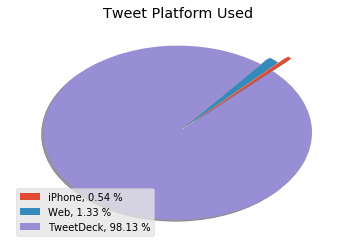

In [179]:
# Make a pie chart with the percentage of tweets posted with each platform.
labels = np.char.array(['iPhone', 'Web', 'TweetDeck'])
sizes = df_analysis.groupby('source').source.count()
percentages = sizes/sizes.sum() * 100
explode = (0.2, 0.1, 0)

plt.title('Tweet Platform Used')
plt.pie(sizes, explode=explode, shadow=True, startangle=45, pctdistance=1.5)
plt.legend(loc='lower left', labels=['%s, %1.2f %%' % (l, s) for l, s in zip(labels, percentages)]);

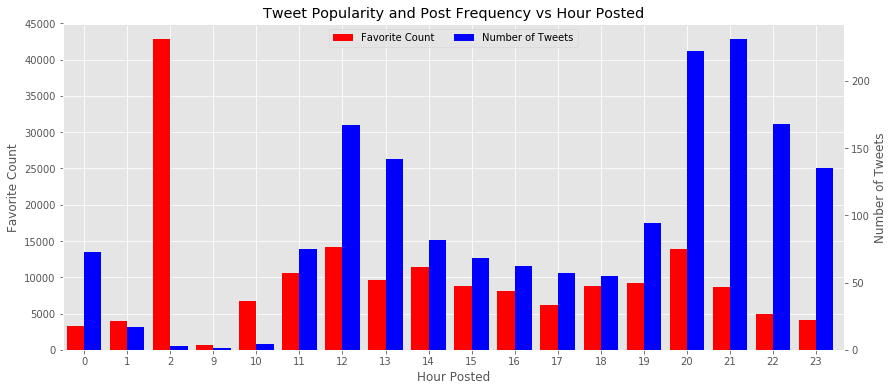

In [181]:
# Make a double bar chart with the number of tweets posted at each hour of the day and the average number of favorites recieved
    # by those tweets.
fav_count_hourly_avg = df_analysis.groupby(df_analysis.hour_posted).favorite_count.mean()
posts_by_hour = df_analysis.groupby(df_analysis.hour_posted).timestamp.count()

fig = plt.figure(figsize=(14,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

plt.xticks(list(range(24)))
plt.title('Tweet Popularity and Post Frequency vs Hour Posted')

fav_count_hourly_avg.plot(kind='bar', color='red', ax=ax, width=width, position=1, rot=0)
ax.set_ylabel('Favorite Count')
ax.set_xlabel('Hour Posted')

posts_by_hour.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, rot=0)
ax2.set_ylabel('Number of Tweets')
ax2.grid(False)
ax.set_xlim(-0.5,)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['Favorite Count'] + ['Number of Tweets'], loc=9, ncol=2);

In [182]:
# Display the favorite_counts of tweets posted at 2 AM.
df_analysis.query('hour_posted == "2"').favorite_count

428     121359
1625      6416
1891       678
Name: favorite_count, dtype: int64

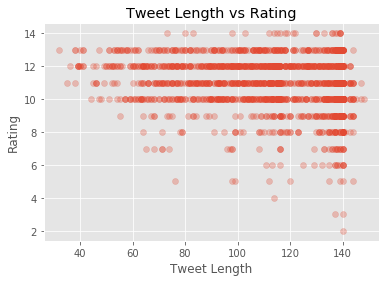

In [185]:
# Make a scatter plot with Tweet Length vs Rating.
plt.title('Tweet Length vs Rating')
plt.xlabel('Tweet Length')
plt.ylabel('Rating')
plt.scatter(df_analysis.tweet_length, df_analysis.rating_numerator, alpha=0.3);